<a href="https://colab.research.google.com/github/jasgcode/tmath495Sp24/blob/master/Heat_equation_with_tensorflow_495Spr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook is a modification of Yanqi's original notebook
[(Version 2) Heat_equation_with_tensorflow.ipynb](https://colab.research.google.com/drive/1o4nZpkxIi-M2sQiB4GniLza3rYGvGrv-)

We consider physics informatnion in the following two methods:

1. Delete the source terms and use the homogeneous equation to model the _interior_ of the trunk. (tested-- not good)

2. Use Yanqi's method and use the source term through the body of the tree trunk. This method is implemented in the original notebook. (notebooks saved in a folder)

This notebook solves the polar heat equation in one dimension

$\rho c \frac{\partial T}{\partial t}=\frac{\partial k}{\partial r}\frac{\partial T}{\partial r}+\frac{k}{r}\frac{\partial T}{\partial r}+k\frac{\partial^2 T}{\partial r^2}+\text{source terms}$

With the assumption that $\frac{\partial k}{\partial r} = 0$, the equation simplifies to

$\rho c \frac{\partial T}{\partial t}=\frac{k}{r}\frac{\partial T}{\partial r}+k\frac{\partial^2 T}{\partial r^2}+\text{source terms}$

The initial condition is included in the solution data $t = 0$. Two boundary conditions are from the measured core and bark temperatures.

We aim to solve the forward problem for predicting the solution of the PDE.


The Physics information within the tree trunk is given by the

$\text{residual} = \frac{\partial T}{\partial t}-\frac{k}{\rho c r}\frac{\partial T}{\partial r}-\frac{k}{\rho c}\frac{\partial^2 T}{\partial r^2}$

The parameters are from various experimental results. These parameters are identified with our measured temperature data, in the inverse problem setting.

## Two terms are in the loss function:

1. At `X_r`: residual of the PDE is computed.
2. At `X`: error of measured and computed solution is computed at these points.

The two terms are then summed up to be in the loss function.

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing

from time import time

tf.experimental.numpy.experimental_enable_numpy_behavior()

import sys
print("Python 3 version is", sys.version)
import matplotlib
print("Matplotlib version is", matplotlib.__version__)
print("Tensorflow version is", tf.__version__)
print("Numpy version is", np.__version__)

Python 3 version is 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Matplotlib version is 3.7.1
Tensorflow version is 2.15.0
Numpy version is 1.25.2


### Hyperparameters, tree trunk dimensions

In [ ]:
DTYPE = 'float64'
tf.keras.backend.set_floatx(DTYPE)

# Set boundary range
tmin = 0.
tmax = 24.
xmin = 0.001
xmax = 0.135

## to do--
## add height variable, direction variable

# define parameter
N_0 = 400
n_t = 4000
radius = 0.135 # unit m
time = np.linspace(0, 24, n_t, endpoint = False)

Set hyperparameters

# **Fetch temperature data from specified date**

In [ ]:
colnames = ['temp_datetime', 's45_1', 'e9_1', 'n135_1','e45_2', 'n9_2', 'w135_2', 'n45_3', 'w9_3','s135_3', 'w_ext_35']
url1 = "https://raw.githubusercontent.com/yajuna/linearRegression/master/Tree_Temp_Values_AUG21_to_AUG28_2022.xlsx"
dataTemp = pd.read_excel(url1,names=colnames)
dataTemp['temp_datetime'] = pd.to_datetime(dataTemp['temp_datetime'])
dataTemp = dataTemp.set_index('temp_datetime')

In [ ]:
train_range = dataTemp.loc['2022-08-21':'2022-08-21 23:59:59']

test_range = dataTemp.loc['2022-08-22':'2022-08-22 23:59:59']

train_temp_size = len(train_range.index)
# linear interpolate the measured temperature
train_coreTemp = np. interp(time, np.linspace(0,24,train_temp_size),train_range.s135_3)
train_midTemp1 = np. interp(time, np.linspace(0,24,train_temp_size),train_range.w9_3)
train_midTemp2 = np. interp(time, np.linspace(0,24,train_temp_size),train_range.n45_3)
train_barkTemp = np. interp(time, np.linspace(0,24,train_temp_size),train_range.w_ext_35)

# read more columns, and correspond temperature values at the z, r, and phi
# values

test_temp_size = len(test_range.index)
test_coreTemp = np. interp(time, np.linspace(0,24,test_temp_size),test_range.s135_3)
test_midTemp1 = np. interp(time, np.linspace(0,24,test_temp_size),test_range.w9_3)
test_midTemp2 = np. interp(time, np.linspace(0,24,test_temp_size),test_range.n45_3)
test_barkTemp = np. interp(time, np.linspace(0,24,test_temp_size),test_range.w_ext_35)

print("measured temperature data read")
# print(train_range)

# print(test_range)

measured temperature data read


In [ ]:
colnames = ['weather_datetime', 'wind_speed', 'wind_direction', 'humidity', 'air_temperature', 'air_pressure', 'solar_DNI']
url2 = "https://raw.githubusercontent.com/yajuna/linearRegression/master/Weather_Station_AUG21_to_AUG28_2022.xlsx"
dataWeather = pd.read_excel(url2,names=colnames)
dataWeather['weather_datetime'] = pd.to_datetime(dataWeather['weather_datetime'])
dataWeather = dataWeather.set_index('weather_datetime')

In [ ]:
train_weather = dataWeather.loc['2022-08-21':'2022-08-21 23:59:59']

test_weather = dataWeather.loc['2022-08-22':'2022-08-22 23:59:59']

train_weather_size = len(train_weather.index)

train_airTemp = np.interp(time, np.linspace(0,24,train_weather_size),train_weather.air_temperature)
train_windSpeed = np.interp(time, np.linspace(0,24,train_weather_size),train_weather.wind_speed)
train_solar = np.interp(time, np.linspace(0,24,train_weather_size),train_weather.solar_DNI)
train_humidity = np.interp(time, np.linspace(0,24,train_weather_size),train_weather.humidity)
train_airPressure = np.interp(time, np.linspace(0,24,train_weather_size),train_weather.air_pressure)

test_weather_size = len(test_weather.index)

test_airTemp = np.interp(time, np.linspace(0,24,test_weather_size),test_weather.air_temperature)
test_windSpeed = np.interp(time, np.linspace(0,24,test_weather_size),test_weather.wind_speed)
test_solar = np.interp(time, np.linspace(0,24,test_weather_size),test_weather.solar_DNI)
test_humidity = np.interp(time, np.linspace(0,24,test_weather_size),test_weather.humidity)
test_airPressure = np.interp(time, np.linspace(0,24,test_weather_size),test_weather.air_pressure)

# print(train_weather)
# print(test_weather)

In [ ]:
# Lower bounds in time and space
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds in time and space
ub = tf.constant([tmax, xmax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# take 4 points for the initial condition, as there are the only measurements at t = 0
t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
x_init = tf.linspace(lb[1], ub[1], N_0)
x_0 = tf.reshape(x_init, (N_0,1))
X_0 = tf.concat([t_0, x_0], axis=1)

# Boundary data- left to be core temperature, and right the bark temperature
t_boundary = tf.linspace(lb[0], ub[0], N_0)
t_b = tf.reshape(t_boundary, (N_0,1))
x_lb = tf.ones((N_0,1), dtype=DTYPE)*lb[1]
x_ub = tf.ones((N_0,1), dtype=DTYPE)*ub[1]
X_lb = tf.concat([t_b, x_lb], axis=1)
X_ub = tf.concat([t_b, x_ub], axis=1)

## Add extra training data at X_train (location at midTemp1)
idx = int(N_0 / 3)
x_train1 = tf.ones((N_0,1), dtype=DTYPE) * x_init[idx]
X_train1 = tf.concat([t_b, x_train1], axis=1)
x_train2 = tf.ones((N_0,1), dtype=DTYPE) * x_init[2 * idx]
X_train2 = tf.concat([t_b, x_train2], axis=1)

# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_0,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)

### Visualize location of data points

Text(0.5, 1.0, 'Location of measured data for training')

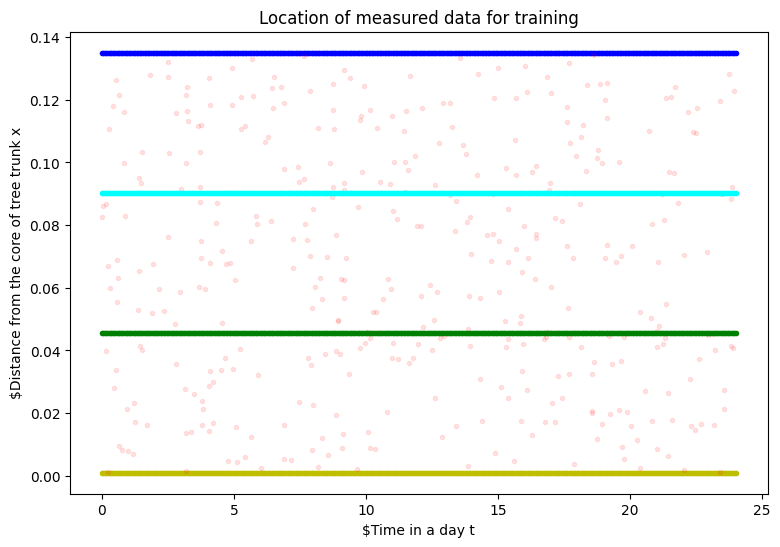

In [ ]:
fig = plt.figure(figsize=(9,6))
# plt.scatter(t_0, x_0, c='k', marker='.')
plt.scatter(t_b, x_lb, c='y', marker='.')
plt.scatter(t_b, x_ub, c='b', marker='.')
plt.scatter(t_r, x_r, c='r', marker='.', alpha=0.1)
plt.scatter(t_b, x_train1, c='g', marker='.')
plt.scatter(t_b, x_train2, c='cyan', marker='.')
plt.xlabel('$Time in a day t')
plt.ylabel('$Distance from the core of tree trunk x')
plt.title('Location of measured data for training')

### Assemble input data for the neural network.

We record space-time information in X_data, and solution values at u_data.

In [ ]:
u_lb = train_coreTemp
u_ub = train_barkTemp
u_train1 = train_midTemp1
u_train2 = train_midTemp2

# collect initial and two boundary data in lists # add training data and points
X_data = [X_lb, X_ub, X_train1, X_train2]
u_data = [u_lb, u_ub, u_train1, u_train2]

## Here we implement the forward problem- our goal is to train a neural network to solve the PDE, with the measured tree temperatures.

We use known coefficients for $k$, $c$, and $\rho$.

thermal_conductivity = 0.16 # denoted by k in paper # pg 3-17, wood handbook.

rho = 720 # kg /m**3

specific_heat = 1300 # denoted by c in paper # table 3-12, at 27 degrees, MC 12%, wood handbook

In [ ]:
k = 0.16
c = 1300
rho = 720

In [ ]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(2))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))

    return model

### Physics information is given by the heat equation.

We compute the loss of physics information at the points `X_r`.

In [ ]:
# Define residual of the cylinder PDE
def fun_r(T_r, T_rr, T_pp, T_zz, T_t, r):

    return k/r * T_x + k*T_xx + (k/r**2 * T_pp + T_t)

## test

In [ ]:
def get_r(model, X)-> tf.Tensor:

    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        t, r, z, phi = X[:, 0:1], X[:,1:2]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(t)
        tape.watch(r)
        tape.watch(z)
        tape.watch(phi)
         # Determine residual
        T = model(tf.stack([t[:,0], x[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        T_r = tape.gradient(T,r)
        T_z = tape.gradient(T,z)
        T_phi = tape.gradient(T,phi)



    T_t = tape.gradient(T, t)
    T_rr = tape.gradient(T_r, r)
    T_pp = tape.gradient(T_phi,phi)
    T_zz = tape.gradient(T_z,z)

    del tape

    return fun_r(T_r, T_rr, T_pp, T_zz, T_t, r)

In [ ]:
def compute_loss(model, X_r, X_data, u_data):

    # Compute phi^r
    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))
    # Initialize loss with interior residual
    loss = phi_r

    # Add phi^0 and phi^b to the loss
    for i in range(len(X_data)):
        u_pred = model(X_data[i])
        loss += tf.reduce_mean(tf.square(u_data[i] - u_pred))

    return loss

In [ ]:
def get_grad(model, X_r, X_data, u_data):

    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, u_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

In [ ]:
# Initialize model aka u_\theta
model = init_model()

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

# lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])
lr = 2e-2

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

### Run four times of a total of 20,000 epochs to see loss = 1e1

In [ ]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, X_data, u_data)

    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss

# Number of training epochs
N = 5000
hist = []

# Start timer
t0 = time()

for i in range(N+1):

    loss = train_step()

    # Append current loss to hist
    hist.append(loss.numpy())

    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 5.65298724e+06
It 00050: loss = 1.36989699e+05
It 00100: loss = 3.40362300e+04
It 00150: loss = 1.95747471e+04
It 00200: loss = 1.23031345e+04
It 00250: loss = 8.59557820e+03
It 00300: loss = 6.67393080e+03
It 00350: loss = 5.60452412e+03
It 00400: loss = 4.93050147e+03
It 00450: loss = 4.44146453e+03
It 00500: loss = 4.04537061e+03
It 00550: loss = 3.70322237e+03
It 00600: loss = 3.39832442e+03
It 00650: loss = 3.12289008e+03
It 00700: loss = 2.87261141e+03
It 00750: loss = 2.64458691e+03
It 00800: loss = 2.43656014e+03
It 00850: loss = 2.24663703e+03
It 00900: loss = 2.07317032e+03
It 00950: loss = 1.91470183e+03
It 01000: loss = 1.76992675e+03
It 01050: loss = 1.63766821e+03
It 01100: loss = 1.51685788e+03
It 01150: loss = 1.40652109e+03
It 01200: loss = 1.30576506e+03
It 01250: loss = 1.21376965e+03
It 01300: loss = 1.12977992e+03
It 01350: loss = 1.05310011e+03
It 01400: loss = 9.83088604e+02
It 01450: loss = 9.19153637e+02
It 01500: loss = 8.60749668e+02
It 01550

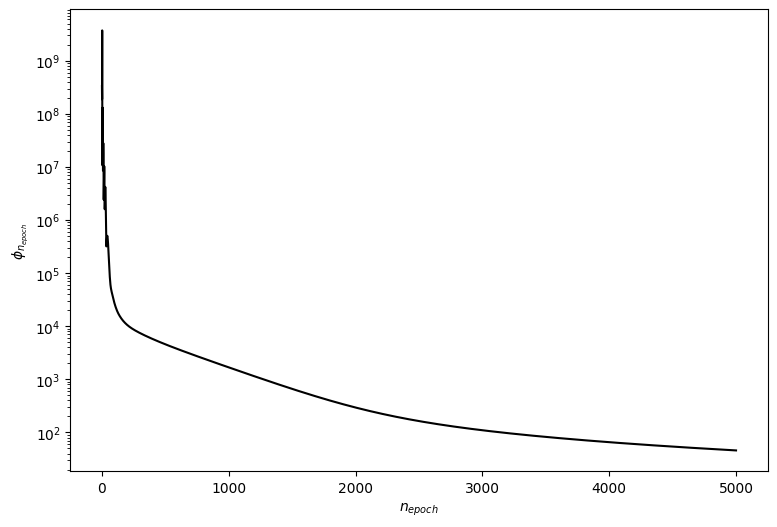

In [ ]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');

# RUN ABOVE FOR INFERENCE SETTING



In [ ]:
 # visualize sourceTerm to compare with cell_test
fig137 = plt.figure(figsize=(9,6))
plt.plot(t_b, sourceTerm_train, color='green', label='sourceTerm')

plt.legend()
plt.title("Source term")

NameError: name 'sourceTerm_train' is not defined

<Figure size 900x600 with 0 Axes>

In [ ]:
# visualize the boundary conditions.
fig1 = plt.figure(figsize=(9,6))
plt.plot(t_b, u_lb, color='green', label='core')
plt.plot(t_b, u_ub, color='red', label='bark')
plt.legend()
plt.title("Boundary temperature at the core")

# RUN BELOW FOR IDENTIFICATION SETTING

Class implementation of PINN. Derive `PINN_NeuralNet` from `tf.keras.Model`.

Required arguments are the lower bound `lb` and upper bound `ub`. This is a general neural net that is equation independent.

In [ ]:
# Define model architecture

class PINN_NeuralNet(tf.keras.Model):
  """Basic architecture of the PINN model
  """

  def __init__(self, lb, ub,
               output_dim = 1,
               num_hidden_layers = 8,
               num_neurons_per_layer = 20,
               activation = 'tanh',
               kernel_initializer = 'glorot_normal',
               **kwargs):
    super().__init__(**kwargs)

    self.num_hidden_layers = num_hidden_layers
    self.output_dim = output_dim
    self.lb = lb
    self.ub = ub

    # Define NN architecture
    self.scale = tf.keras.layers.Lambda(
            lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                             activation=tf.keras.activations.get(activation),
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.num_hidden_layers)]
    self.out = tf.keras.layers.Dense(output_dim)

  def call(self, X):
    """
    Forward-pass thru NN
    """
    Z = self.scale(X)
    for i in range(self.num_hidden_layers):
      Z = self.hidden[i](Z)
    return self.out(Z)

Derive from the above neural net class to take in additional parameters `lambd1`, `lambd2`.

In [ ]:
class PINNIdentificationNet(PINN_NeuralNet):
    def __init__(self, *args, **kwargs):

        # Call init of base class
        super().__init__(*args,**kwargs)

        # Initialize variable for lambda
        # initial guess: lambd1 = 0.16 / (720 * 1300), lambd2 = 1.0 / (720 * 1300)

        self.lambd1 = tf.Variable(0.3/(1.38 * 510), trainable=True, dtype=DTYPE)
        self.lambd1_list = []

        self.lambd2 = tf.Variable(1./(1.38 * 510), trainable=True, dtype=DTYPE)
        self.lambd2_list = []

        self.lambd3 = tf.Variable(0.3/(1.38 * 510), trainable=True, dtype=DTYPE)
        self.lambd3_list = []

        self.lambd4 = tf.Variable(1./(1.38 * 510), trainable=True, dtype=DTYPE)
        self.lambd4_list = []

Define base class `PINNSolver`. This is equation dependent. Components to customize are

1. get_r <---- modify what derivatives are computed
2. loss_fn <--- modify the boundary conditions
3. fun_r <--- residual of the PDE
4. should check all functions if boundary data were changed

Here we only consider the method based on tensorflow optimizer object as input. The [original notebook](https://colab.research.google.com/github/janblechschmidt/PDEsByNNs/blob/main/PINN_Solver.ipynb#scrollTo=wcOkamgfZEks) though, also has method based on SciPy's LBFGS method.

In [ ]:
class PINNSolver():
    def __init__(self, model, X_r):
        self.model = model

        # Store collocation points, separate t and x
        self.t = X_r[:,0:1]
        self.x = X_r[:,1:2]

        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0

    def get_r(self):

        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing t and x during this GradientTape
            tape.watch(self.t)
            tape.watch(self.x)

            # Compute current values u(t,x)
            u = self.model(tf.stack([self.t[:,0], self.x[:,0]], axis=1))

            u_x = tape.gradient(u, self.x)

        u_t = tape.gradient(u, self.t)
        u_xx = tape.gradient(u_x, self.x)

        del tape

        return self.fun_r(self.t, self.x, u, u_t, u_x, u_xx) ########


    def loss_fn(self, X, u):

        # Compute phi_r
        r = self.get_r()
        phi_r = tf.reduce_mean(tf.square(r))

        # Initialize loss
        loss = phi_r

        # Add phi_0 and phi_b to the loss
        for i in range(len(X)):
            u_pred = self.model(X[i])
            loss += tf.reduce_mean(tf.square(u[i] - u_pred))

        return loss


    def get_grad(self, X, u):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.model.trainable_variables)
            loss = self.loss_fn(X, u)

        g = tape.gradient(loss, self.model.trainable_variables)
        del tape

        return loss, g


    def fun_r(self, t, x, u, u_t, u_x, u_xx):
        """Residual of the PDE"""
        ## introduce lambd_3, lambd_4 and separate sourceTerm_train
        sourceTerm_train = self.model.lambd2 * train_solar + self.model.lambd3 * (train_airTemp**4 - u_ub**4) + self.model.lambd4 * convect_train
        return u_t - self.model.lambd1 * 1./ x * u_x - self.model.lambd1 * u_xx - self.model.lambd2 * sourceTerm_train

    def solve_with_TFoptimizer(self, optimizer, X, u, N=1001):
        """This method performs a gradient descent type optimization."""

        @tf.function
        def train_step():
            loss, grad_theta = self.get_grad(X, u)

            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            return loss

        for i in range(N):

            loss = train_step()

            self.current_loss = loss.numpy()
            self.callback()

    def callback(self, xr=None):
        lambd1 = self.model.lambd1.numpy()
        self.model.lambd1_list.append(lambd1)

        lambd2 = self.model.lambd2.numpy()
        self.model.lambd2_list.append(lambd2)

        lambd3 = self.model.lambd3.numpy()
        self.model.lambd1_list.append(lambd3)

        lambd4 = self.model.lambd4.numpy()
        self.model.lambd2_list.append(lambd4)


        if self.iter % 100 == 0:
            print('It {:05d}: loss = {:10.8e} lambda1 = {:10.8e} lambda2 = {:10.8e} lambda3 = {:10.8e} lambda4 = {:10.8e}'.format(self.iter, self.current_loss, lambd1, lambd2, lambd3, lambd4))

        self.hist.append(self.current_loss)
        self.iter += 1


    def plot_solution(self, **kwargs):
        N = 411
        tspace = np.linspace(self.model.lb[0], self.model.ub[0], N)
        xspace = np.linspace(self.model.lb[1], self.model.ub[1], N)
        T, X = np.meshgrid(tspace, xspace)
        Xgrid = np.vstack([T.flatten(),X.flatten()]).T
        upred = self.model(tf.cast(Xgrid,DTYPE))
        U = upred.numpy().reshape(N,N)
        fig = plt.figure(figsize=(9,6))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(T, X, U, cmap='viridis', **kwargs)
        ax.set_xlabel('$t$')
        ax.set_ylabel('$x$')
        ax.set_zlabel('$u_{\theta}(t,x)$')
        ax.view_init(35,35)
        return ax

    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7,5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist,'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

    def plot_loss_and_param(self, axs=None):
        if axs:
            ax1, ax2 = axs
            self.plot_loss_history(ax1)
        else:
            ax1 = self.plot_loss_history()
            ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        # color = 'tab:blue'
        ax2.tick_params(axis='y', labelcolor='tab:blue')
        ax2.plot(range(len(self.hist)), self.model.lambd1_list,'-',color='tab:blue')
        ax2.plot(range(len(self.hist)), self.model.lambd2_list,'-',color='tab:red')
        ax2.plot(range(len(self.hist)), self.model.lambd3_list,'-',color='tab:green')
        ax2.plot(range(len(self.hist)), self.model.lambd4_list,'-',color='tab:black')
        ax2.set_ylabel('$\\lambda^{n_{epoch}}$', color='tab:blue')
        return (ax1,ax2)

Initialize model and solver.

In [ ]:
# initialize model
model = PINNIdentificationNet(lb, ub, num_hidden_layers=2)
model.build(input_shape=(None,2))

# initialize PINN solver
solver = PINNSolver(model, X_r)

Start training

In [ ]:
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])
optim = tf.keras.optimizers.Adam(learning_rate=lr)

EPOCH = 6000

# start timer
t0 = time()

solver.solve_with_TFoptimizer(optim, X_data, u_data, N=EPOCH)

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

Plot solution and loss history

In [ ]:
solver.plot_solution();


In [ ]:

solver.plot_loss_history();


In [ ]:

solver.plot_loss_and_param();

# Cells below replace cells after "Class implementation of PINN..."

## As of now, the error in computation seems more like coding error (1e5) rather than logic error (expected 1e0), so we work on the following methods to debug

Write a simplified forward problem; eliminate parameter identification problem, and use $\lambda_1$ and $\lambda_2$ that worked for FD problem in cell_test. These values should be

$\lambda_1=k/\rho c=0.3/(1.38 * 510)$ and $\lambda_2=1/\rho c=0.3/(1.38 * 510)$. We will see if the errors are still very big.

The code below is modified from

https://github.com/yajuna/tensorflow_pde/blob/master/Simple_PDE_with_tensorflow.ipynb


In [ ]:
lambd1 = 0.3/(1.38 * 510)
lambd2 = 1./(1.38 * 510)

In [ ]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(2))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))

    return model


In [ ]:
def get_r(model, X_r)-> tf.Tensor:

    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        t, x = X_r[:, 0:1], X_r[:,1:2]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(t)
        tape.watch(x)

        # Determine residual
        u = model(tf.stack([t[:,0], x[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_x = tape.gradient(u, x)
        u_t = tape.gradient(u, t)

    u_xx = tape.gradient(u_x, x)

    del tape

    return u_t - 1./x * lambd1 * u_x - lambd1 * u_xx - lambd2 * sourceTerm_train

In [ ]:
model = init_model(num_hidden_layers = 2)
r = get_r(model, X_0)
phi_r = tf.reduce_mean(tf.square(r))
loss = phi_r

print(X_0.shape)
print(X_0[1].shape)


In [ ]:
def compute_loss(model, X_r, X_data, u_data)-> tf.Tensor:

    # Compute phi^r-- physics informed loss
    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))

    # Initialize loss
    loss = phi_r

    # Add initial error loss; add boundary loss

    for i in range(len(X_data)):
        u_pred = model(X_data[i])
        loss += tf.reduce_mean(tf.square(u_data[i] - u_pred))

        return loss

    ## define customized loss-- max(abs(u_data and u_pred))


    return loss

In [ ]:
loss = compute_loss(model, X_r, X_data, u_data)

In [ ]:
def get_grad(model, X_r, X_data, u_data):

    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, u_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

In [ ]:
# Initialize model aka u_\theta
model = init_model(num_hidden_layers = 2)
# print(model.layers[0].input_shape)

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

In [ ]:
# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step()-> tf.Tensor:
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, X_data, u_data)

    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss

# Number of training epochs
EPOCH = 50000
hist = []

# Start timer
t0 = time()

for i in range(EPOCH+1):

    loss = train_step()

    # Append current loss to hist
    hist.append(loss.numpy())

    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

In [ ]:
# Interactive plotting tools
# visualization tools
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from typing import Tuple, Iterable

N = 600
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)

Xgrid = np.vstack([T.flatten(),X.flatten()]).T
# Determine predictions of u(t, x)
upred = model(tf.cast(Xgrid,DTYPE))

# Reshape upred
U = upred.numpy().reshape(N+1,N+1)

# draw plane
surface = go.Surface(x=T, y=X, z=U, colorscale="phase", showscale=False)

# create figure
fig317 = make_subplots(rows=1, cols=1, specs=[[{'type': 'surface'}]])
fig317.add_trace(surface, row=1, col=1)

fig317.show()

In [ ]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');


In [ ]:
# from mpl_toolkits.mplot3d import Axes3D

# # Set up meshgrid
# N = 600
# tspace = np.linspace(lb[0], ub[0], N + 1)
# xspace = np.linspace(lb[1], ub[1], N + 1)
# T, X = np.meshgrid(tspace, xspace)
# Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# # Determine predictions of u(t, x)
# upred = model(tf.cast(Xgrid,DTYPE))

# # Reshape upred
# U = upred.numpy().reshape(N+1,N+1)

# # Surface plot of solution u(t,x)
# fig = plt.figure(figsize=(9,6))
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(T, X, U, cmap='viridis');
# ax.view_init(40,40)
# ax.set_xlabel('$t$')
# ax.set_ylabel('$x$')
# ax.set_zlabel('$u_{\theta}(t,x)$')
# ax.set_title('Solution of heat equation');
# #plt.savefig('wave_Solution.pdf', bbox_inches='tight', dpi=300);
